# 180-degree beam bending
-  Magneto-viscoelasticity of hard-magnetic soft-elastomers

- Bending of a hard-magnetic beam subjected to a linearly ramped-up magnetic b-field.

# Units

- Basic units:
    - Length: mm
    - Time: s
    - Mass: kg
    - Charge: kC
    

- Derived units: 
    - Force: mN
    - Pressure: kPa
    - Current: kA
    - Mag. flux density: mT


In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, outer, cos, acos, lt, eq, ge, le)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Overall dimensions of rectangular prism device
scaleX = 17.2   # mm
scaleY = 0.84   # mm
scaleZ = 5.0    # mm

# N number of elements in each direction    
Xelem = 20
Yelem = 4
Zelem = 4

domain = mesh.create_box(MPI.COMM_WORLD, [[0.0,0.0,0.0], [scaleX, scaleY, scaleZ]],\
                         [Xelem, Yelem, Zelem], mesh.CellType.tetrahedron)

# This says "spatial coordinates" but is really the referential coordinates,
# since the mesh does not convect in FEniCS.
x = ufl.SpatialCoordinate(domain) 

**Identify boundaries of the domain**

In [3]:
# Identify the planar boundaries of the  box mesh
#
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], scaleX)
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], scaleY)
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], scaleZ)
    
# Mark the sub-domains
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# build collections of facets on each subdomain and mark them appropriately.
facet_indices, facet_markers = [], [] # initalize empty collections of indices and markers.
fdim = domain.topology.dim - 1 # geometric dimension of the facet (mesh dimension - 1)
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator) # an array of all the facets in a 
                                                         # given subdomain ("locator")
    facet_indices.append(facets)                         # add these facets to the collection.
    facet_markers.append(np.full_like(facets, marker))   # mark them with the appropriate index.

# Format the facet indices and markers as required for use in dolfinx.
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
# 
# Add these marked facets as "mesh tags" for later use in BCs.
facet_tags = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain (facets)
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Surface numbering:
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

[1 2 3 4 5 6]


**Visualize reference configuration and boundary facets**

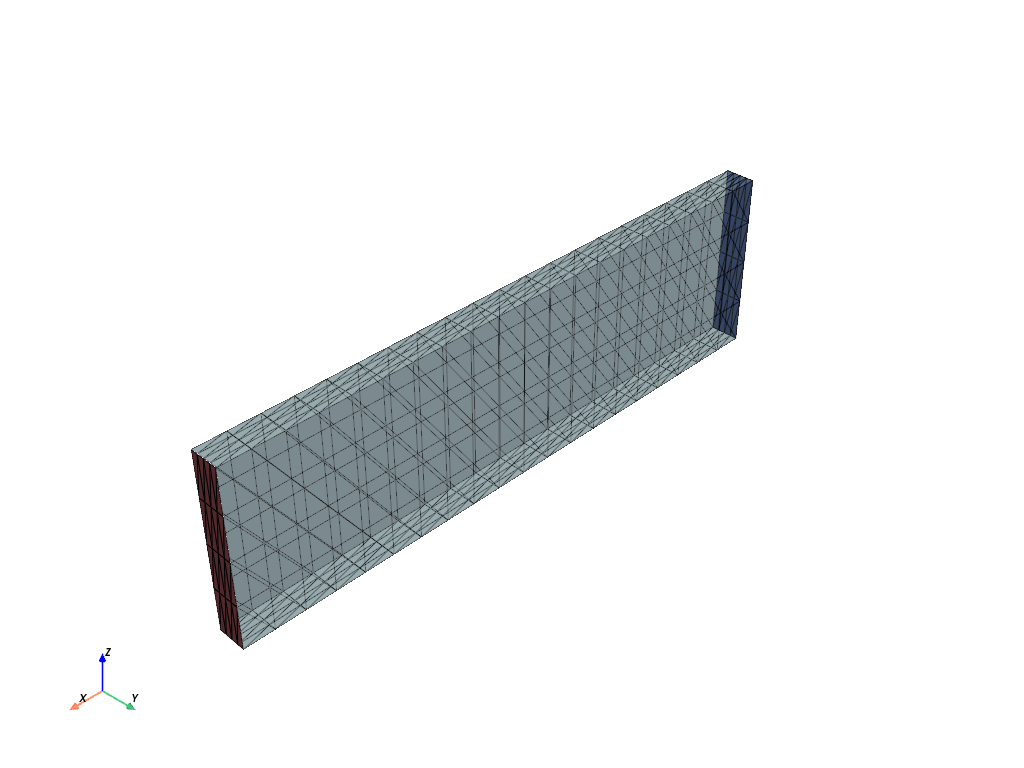

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh -- I make the 3D mesh opaque, so that 2D surfaces stand out.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.5) 

# Add colored 2D surfaces for the named surfaces
zBot_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==1]) )
zTop_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==2]) )
#
actor = plotter.add_mesh(zBot_surf, show_edges=True,color="blue") # zBot face is blue
actor2 = plotter.add_mesh(zTop_surf, show_edges=True,color="red") # zTop is red

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/mesh.png")

from IPython.display import Image
Image(filename='results/mesh.png') 

# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("mesh.png")

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 2})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parameters

In [7]:

# Neo-Hookean elasticity
Gshear0 = Constant(domain, PETSc.ScalarType(303)) # kPa
Kbulk   = Constant(domain, PETSc.ScalarType(1e3*Gshear0)) # Nearly-incompressible

# Mass density
rho = Constant(domain, PETSc.ScalarType(2.00e-6)) # 2.00e3 kg/m^3 = 2.00e-6 kg/mm^3

# alpha-method parameters
alpha   = Constant(domain, PETSc.ScalarType(0.0))
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType(0.25*(gamma+0.5)**2))

# Visco dissipation switch, 0=dissipative,  1=~lossless
disableDissipation = Constant(domain, PETSc.ScalarType(1.0))
#
# When enabled, this switch sets the relaxation times arbitrarily high, 
# so that the stiffness remains the same but no energy is dissipated 
# because the tensor variables A_i are constant.

# Viscoelasticity parameters
#
Gneq_1  = Constant(domain, PETSc.ScalarType(500.0))    #  Non-equilibrium shear modulus, kPa
tau_1   = Constant(domain, PETSc.ScalarType(0.010))    #  relaxation time, s

# Set relaxation times arbitrarily high if visco dissipation is off
tau_1 = tau_1 + disableDissipation/3e-12

# Vacuum permeability
mu0 = Constant(domain, PETSc.ScalarType(1.256e-6*1e9)) # mN / mA^2

# Remanent magnetic flux density magnitude
b_rem_mag = 0.114*float(mu0) # mT

# Some small misalignment is needed so that the two magnetic fields are not
#  initially perfectly parallel, in which case there is no magnetic torque.
#
angle_imperf = 5.0*np.pi/180 # imperfection in degrees, converted to radians
#                            # with the factor np.pi/180
#
# Apply imperfection angle
x_mag = np.cos(angle_imperf)
y_mag = np.sin(angle_imperf)
z_mag = 0.0

# Need some extra infrastructure for the spatially-discontinuous material property fields
U0 = element("DG", domain.basix_cell(), 0, shape=(3,))   # For remanent magnetization vector
V0 = functionspace(domain, U0) # create a vector DG0 function space on the domain
#
b_rem = Function(V0) # define a ground state shear modulus which lives on this function space.

# A function for constructing the desired magnetization distribution:
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def magnetization(x):
    values = np.zeros((domain.geometry.dim,
                      x.shape[1]), dtype=np.float64)
    #
    values[0, :] = x_mag*b_rem_mag
    values[1, :] = y_mag*b_rem_mag
    values[2, :] = 0.0
    #
    return values
        
b_rem.interpolate(magnetization)



## Showing the material properties in a plotter 

In [8]:
# Prepare the magnetization field for plotting
Up = element("Lagrange", domain.basix_cell(), 1, shape=(3,)) # For displacement# For visualizing the remanent magnetization vector
Vp = functionspace(domain, Up) # create a vector DG1 function space on the domain
vtkdata = vtk_mesh(Vp)  
grid = pyvista.UnstructuredGrid(*vtkdata)
# 
# Need to interpolate the DG0 b_rem into a DG1 b_rem_temp
# so that Pyvista can visualize it
# (Pyvista is allergic to 0'th order spaces)
b_rem_temp = Function(Vp)
b_rem_expr = Expression(b_rem, Vp.element.interpolation_points())
b_rem_temp.interpolate(b_rem_expr)
#
# Now some data formatting:
num_nodes       = b_rem_temp.function_space.dofmap.index_map.size_global # get the number of nodes on the visualization function space.
b_rem_plot_data = np.reshape(b_rem_temp.x.array[:], (num_nodes, 3)) # reshape the b_rem array into the shape Pyvista expects.

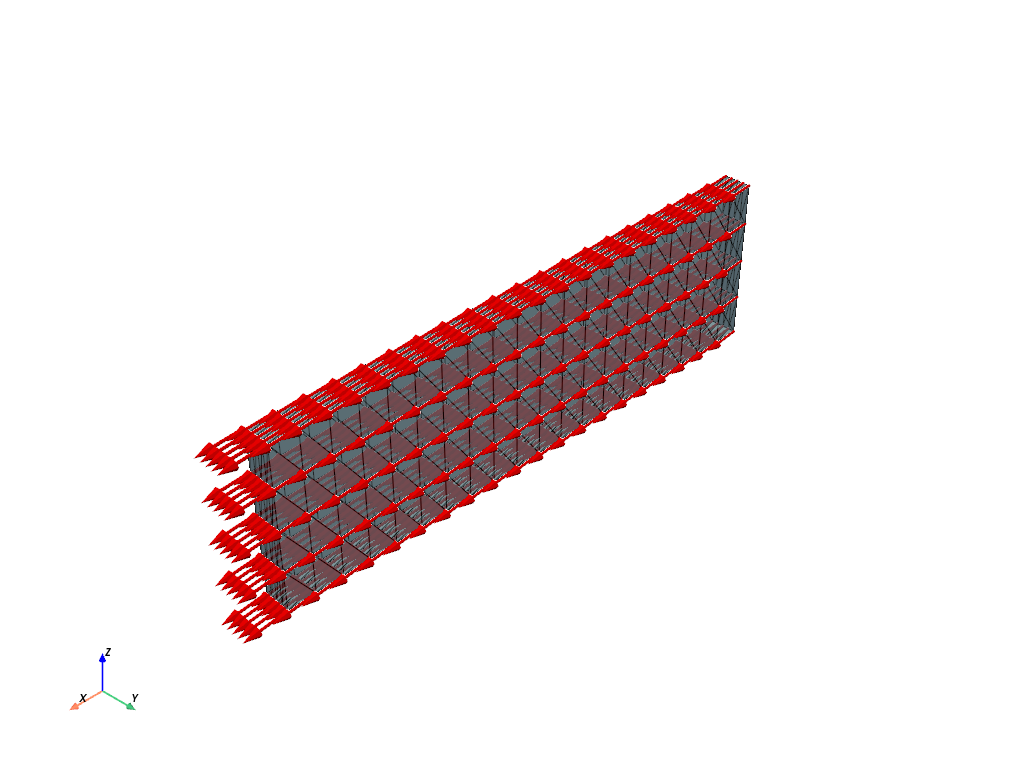

In [9]:
pyvista.set_jupyter_backend('html')
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh -- I make the 3D mesh opaque, so that 2D surfaces stand out.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid_msh = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid_msh, show_edges=True, opacity=0.75) 

# set up another grid for the vector space
vtkdata = vtk_mesh(Vp)  
grid = pyvista.UnstructuredGrid(*vtkdata)

# Add the b_rem data.
grid["b_rem"] = b_rem_plot_data
#
# Set the b_rem item as the active field to plot.
grid.set_active_vectors("b_rem")

# Add the arrow plot.
mag_arrow = grid.glyph(orient="b_rem", factor=0.01)
actor = plotter.add_mesh(mag_arrow, color="red") # plot magnetization values.

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

plotter.screenshot("results/magnetization.png")

from IPython.display import Image
Image(filename='results/magnetization.png') 

# if not pyvista.OFF_SCREEN:
#    plotter.show()
# else:
#    plotter.screenshot("magnetization.png")

# Simulation time-control related params

In [10]:
#Simulation time related params
t = 0.0         # initialization of time  
# total simulation time 
step_time = 1.0 # s
# Float value of time step
dt = step_time/100 # time step size, seconds
# Compiler variable for time step
dk = Constant(domain, PETSc.ScalarType(dt)) # UFL Constant for the time step, used in time integration.

# Max applied magnetic flux density magnitude
b_app_max = 40.0 # mT

# expression for ramping up the b-field
def bRamp(t):
    value = b_app_max*t/step_time
    return value

# Create a constant for the applied magnetic field
bRampCons = Constant(domain,PETSc.ScalarType(bRamp(0)))
#
# vector form of the applied b-field
b_app = ufl.as_vector([-bRampCons,0,0])


# Function spaces

In [ ]:
# Define desired element types, for scalar vector and tensor functions.
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)  # For  pressure  
P0 = quadrature_element(domain.basix_cell(), degree=2, scheme="default") 
# Note: it seems that for the current version of dolfinx, 
# only degree=2 quadrature elements actually function properly 
# for e.g. problem solution and interpolation.
T0 = basix.ufl.blocked_element(P0, shape=(3, 3)) # for A tensors                              

# Set up the mixed function space of degrees of freedom (u,p)
TH = mixed_element([U2, P1])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w    = Function(ME)
u, p = split(w)  # displacement u, pressure p

# A copy of functions to store values in the previous step
w_old         = Function(ME)
u_old,  p_old = split(w_old)   

# Define test functions        
u_test, p_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)   

#  Define vector spaces for storing old values of velocity and acceleration
W2 = functionspace(domain, U2)  # Vector space  

# Functions for storing the velocity and acceleration at prev. step
v_old = Function(W2)
a_old = Function(W2)

# Set up Cv tensor as an internal variable
#
V3     = functionspace(domain, T0) # Tensor function space
Cv_old = Function(V3)              # initialize the Cv_old tensor

# Initial conditions

- The initial conditions for degrees of freedom $\mathbf{u}$,  $\mathbf{v}$, $\mathbf{a}$, and $p$ are zero everywhere
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the initial condition that $\mathbf{C}^v = \mathbf{1}$. This is done below.

In [12]:
# A function for constructing the identity matrix:
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def identity(x):
    values = np.zeros((domain.geometry.dim*domain.geometry.dim,
                      x.shape[1]), dtype=np.float64)
    values[0] = 1
    values[4] = 1
    values[8] = 1 
    return values

# interpolate the identity onto the tensor-valued Cv function.
Cv_old.interpolate(identity)  

# At each time step, the current Cv tensor will be calculated as a function of Cv_old and 
# other kinematical quantities which are known.

# Subroutines for kinematics and constitutive equations

In [13]:
# Deformation gradient 
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

#----------------------------------------------------------------------------------------------------
# Subroutine for computing the eigenvalues of a tensor A.
#
# Modeled after Ang et al., 2022. Cf. e.g.:
# https://github.com/idaang267/StabilizedPhaseFieldFracture/blob/main/Code/3D-hybrid-stabilized.py
#----------------------------------------------------------------------------------------------------
def eigenvalues(A):

    # Define identity tensor
    Id = Identity(3)
    
    # Invariants
    I1 = tr(A)
    I2 = ((tr(A))**2-tr(A*A))/2.
    I3 = det(A) # I2 and I3 are not actually used anywhere, but 
                          # are left here for completeness.

    # Define some parameters for the eigenvalues
    d_par = I1/3.
    e_par = safe_sqrt( tr( (A-d_par*Id)*(A-d_par*Id) ) /6. )
    
    # conditional for case of a spherical tensor, 
    # which has all eigenvalues equal.
    #
    zero = 0*Id
    f_par_expr = (1./e_par)*(A-d_par*Id)
    #
    # if e_par=0, f_par = zero tensor, otherwise f_par = (1./e_par)*(A-d_par*Id).
    f_par = conditional(eq(e_par, 0), zero, f_par_expr)

    # g_par is the argument of ’acos’. 
    g_par0 = det(f_par)/2.
    
    # must bound the argument of 'acos' both from above and from below.
    # This accounts for the cases of multiplicity 2.
    #
    tol = 3.e-16 # numerical "epsilon" tolerance for the bounds, same as DOLFIN_EPS
    #
    # First, if g_par0 = 1 subtract the tolerance so that g_par1 < 1.
    g_par1 = conditional(ge(g_par0, 1.-tol), 1.-tol, g_par0)
    #
    # Then, if g_par1 = -1 add the tolerance so that g_par > -1.
    g_par = conditional(le(g_par1, -1.+tol), -1.+tol, g_par1)

    # carry out the arccos operation.
    h_par = acos(g_par)/3.
    
    # Compute the eigenvalues of A such that lmbda1s >= lmbda2s >= lmbda3s
    lmbda3s = d_par + 2.*e_par*cos(h_par + 2.*np.pi/3.)
    lmbda2s = d_par + 2.*e_par*cos(h_par + 4.*np.pi/3.)
    lmbda1s = d_par + 2.*e_par*cos(h_par + 6.*np.pi/3.)
    
    # return an ordered vector of eigenvalues
    return lmbda1s, lmbda2s, lmbda3s

#--------------------------------------------------------------------------------------------
# Subroutine for the right polar decomposition.
# 
# We compute U and R using the methods of Hoger and Carlson (1984) for computing U^{-1}.
#--------------------------------------------------------------------------------------------
def right_decomp(F):
    # Identity tensor.
    Id = Identity(3)

    # invariants of C.
    C = F.T*F
    #
    I1C = tr(C)
    I2C = (1/2)*(tr(C)**2 - tr(C*C))
    I3C = det(C)

    # Compute the maximum eigenvalue of U, using the fact that C = U^2.
    #
    lam1, lam2, lam3 = eigenvalues(C) # get the ordered eigenvalues of C, lam1 > lam2 > lam3.
    #
    lambdaU = safe_sqrt(lam1) # the eigenvalues of U are the sqrt of the eigenvalues of C.
    
    # U invariants:
    I3U = safe_sqrt(I3C)
    I2U = safe_sqrt(I3C)/lambdaU + safe_sqrt(I1C*(lambdaU**2) - lambdaU**4 + 2*safe_sqrt(I3C)*lambdaU)
    I1U = lambdaU + safe_sqrt(I1C - lambdaU**2 + 2*safe_sqrt(I3C)/lambdaU )
    
    # intermediate quantity \Delta:
    deltaU = I1U*I2U - I3U
    
    # final expression for U^{-1} tensor:
    Uinv = ((I3U*deltaU)**(-1))*( \
                    + (I1U)*(C*C) \
                    - ( I3U + I1U**3 - 2*I1U*I2U)*C \
                    + (I1U*(I2U**2)  - I3U*(I1U**2) - I3U*I2U)*Id )
    
    # Finally, compute U and R:
    R = F*Uinv
    U = R.T*F

    return R, U

#------------------------------------------------------------- 
# Subroutines for computing the viscous flow update
#-------------------------------------------------------------

# subroutine for the distortional part / unimodular part of a tensor A
def dist_part(A):

    Abar = A / (det(A)**(1.0/3.0))

    return Abar

# Subroutine for computing the viscous stretch Cv at the end of the step.
def Cv_update(u, Cv_old, tau_r):
    
   F = F_calc(u)
   
   J = det(F)
   
   C = F.T*F
   
   Cv_new = dist_part( Cv_old + ( dk / tau_r ) * J**(-2./3.) * C ) 
    
   return Cv_new


#----------------------------------------------
# Subroutine for calculating the Piola stress
#----------------------------------------------

# Subroutine for the non-equilibrium Cauchy stress.
def T_neq_calc(u, Cv, Gneq):
        
    F  = F_calc(u)
    
    J = det(F)
    
    C = F.T*F
    
    T_neq = J**(-5./3.) * Gneq * (F * inv(Cv) * F.T - (1./3.) * inner(C, inv(Cv)) * Identity(3) ) 
    
    return T_neq
    
    
def Piola_calc(F, R, U, p, b_app, Cv):
    
    Id = Identity(3)
    
    J = det(F)
    C = F.T*F
    Cdis = J**(-2/3)*C
     
    # Calculate the derivative dRdF after Chen and Wheeler (1992)
    #
    Y = tr(U)*Id - U # helper tensor Y 
    #
    Lmat = -outer(b_app, b_rem)/mu0 # dRdF will act on this tensor
    #
    # For the R-based mapping, use the following line:
    T_mag = R*Y*(R.T*Lmat - Lmat.T*R)*Y/det(Y)
    #
    # If using the F-based mapping, the following line is the magnetic 
    #  contribution to the Piola stress:
    #T_mag = -outer(b_app, m_rem)
    
    # The viscous Piola stress
    #
    T_visc = T_neq_calc(u, Cv, Gneq_1)
    
    # Piola stress
    Tmat = J**(-2/3)*Gshear0*(F - 1/3*tr(C)*inv(F.T)) \
        + J*p*inv(F.T) + T_mag #+ J*T_visc*inv(F.T)
    
    return Tmat

#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Evaluate kinematics and constitutive relations

In [14]:
# Get acceleration and velocity at end of step
a_new = update_a(u, u_old, v_old, a_old)
v_new = update_v(a_new, u_old, v_old, a_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
p_avg  = avg(p_old, p, alpha)

# Kinematic relations
F =  F_calc(u_avg)  
J = det(F)
lambdaBar = lambdaBar_calc(u_avg)

# Right polar decomposition
R, U = right_decomp(F)

# update the Cv tensor
Cv = Cv_update(u_avg, Cv_old, tau_1)

# Piola stress
Tmat = Piola_calc(F, R, U, p_avg, b_app, Cv)

# Weak forms

In [15]:
# Residuals:
# Res_0: Equation of motion (test fxn: u)
# Res_1: Coupling pressure  (test fxn: p)

# The weak form for the equation of motion. No body force.
Res_0 = inner(Tmat , grad(u_test) )*dx \
         # + inner(rho * a_new, u_test)*dx 

# The weak form for the pressure
Res_1 = dot( (J-1) - p_avg/Kbulk, p_test)*dx

# Total weak form
Res = (1/Gshear0)*Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [16]:
# results file name
results_name = "hardmagnetic_180deg_bend"

# Function space for projection of results
U1 = element("Lagrange", domain.basix_cell(), 1, shape=(3,)) # For displacement
V2 = fem.functionspace(domain, U1) #Vector function space
V1 = fem.functionspace(domain, P1) #Scalar function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# Write the spatial m_rem
m_rem = R*b_rem/det(F)/mu0*1000 # units of kA/m
#
m_vis = Function(V2, name="m_rem")
m_expr = Expression(m_rem, V2.element.interpolation_points())

# Write the magnitude of R*m^rem_mat
# (this will be a constant if R is computed correctly)
Rm_rem  = R*b_rem/mu0*1000 # units of kA/m
m_mag  = safe_sqrt(dot(Rm_rem, Rm_rem))
m_mag_vis = Function(V1, name="|R m^rem_mat|")
m_mag_expr = Expression(m_mag, V1.element.interpolation_points())
    
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, J_vis, P11, P22, P33, lambdaBar_vis,
        Mises_vis, m_vis, m_mag_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)
       m_vis.interpolate(m_expr)
       m_mag_vis.interpolate(m_mag_expr)
       
       # Write output fields
       file_results.write(t) 
        
        

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [17]:
# infrastructure for evaluating functions at a certain point efficiently
pointForDisp = np.array([scaleX, scaleY, scaleZ])
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array

## Boundary condtions

In [18]:
# Surface numbering:
# boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

# Find the specific DOFs which will be constrained.
#
# Bottom surface displacement degrees of freedom
Btm_dofs_u1 = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1))
Btm_dofs_u2 = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(1))
Btm_dofs_u3 = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(1))

# Build the Dirichlet BCs
bcs_0 = dirichletbc(0.0, Btm_dofs_u1, ME.sub(0).sub(0))  # u1 fix    - xBtm
bcs_1 = dirichletbc(0.0, Btm_dofs_u2, ME.sub(0).sub(1))  # u2 fix    - xBtm
bcs_2 = dirichletbc(0.0, Btm_dofs_u3, ME.sub(0).sub(2))  # u3 fix    - xBtm

# collect all BCs in one object.
bcs = [bcs_0, bcs_1, bcs_2]

## Define the nonlinear variational problem

In [19]:
# # Optimization options for the form compiler

# Legacy FEniCS compiler options:
# parameters["form_compiler"]["cpp_optimize"] = True
# parameters["form_compiler"]["representation"] = "uflacs"
# parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"

# Analog for some options in dolfinx:
# jit_options ={"cffi_extra_compile_args":["-march=native","-O3","-ffast-math"]}
# problem = NonlinearProblem(Res, w, bcs, a, jit_options=jit_options)
#
# For now, we leave these options out.

# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()



##  Start calculation loop

In [20]:
# Give the step a descriptive name
step = "Snap"

# Variables for storing time history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 

#Iinitialize a counter for reporting data
ii=0

#  Set up temporary "helper" functions and expressions 
#  for updating the internal variable Cv tensors. 
Cv_temp = Function(V3)
#
Cv_expr = Expression(Cv,V3.element.interpolation_points())
#
# and also for the velocity and acceleration.
v_temp = Function(W2)
a_temp = Function(W2)
#
v_expr = Expression(v_new,W2.element.interpolation_points())
a_expr = Expression(a_new,W2.element.interpolation_points())

# Write initial state to file
writeResults(t=0.0)  

# Print out message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()  

# Time-stepping solution procedure loop
while (round(t,4) <= round(step_time,4)):

    # increment counter
    ii += 1

    # update time and time-varying BCs
    t += dt
    bRampCons.value = bRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        file_results.close()
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)

    # Store time history variables at this time  
    timeHist0[ii] = t # current time
    #
    timeHist1[ii] =  bRamp(t) # time history of applied b-field
    #
    timeHist2[ii] =  w.sub(0).sub(1).eval([scaleX, scaleY, scaleZ],colliding_cells[0])[0] # time history of tip displacement
   
    # Then, update state variables for next step
    Cv_temp.interpolate(Cv_expr)
    # 
    # And also the velocity and acceleration
    # ( v -> v_old, a -> a_old )
    v_temp.interpolate(v_expr)
    a_temp.interpolate(a_expr)
    #
    # update DOFs for next step
    w_old.x.array[:] = w.x.array
    #
    # Set "old" values of internal variables for next step 
    Cv_old.x.array[:] = Cv_temp.x.array[:]
    v_old.x.array[:] = v_temp.x.array[:]
    a_old.x.array[:] = a_temp.x.array[:]
    
    
    # Print progress of calculation
    if ii%5 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), step_time))
        print()   
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Snap | Increment: 5, Iterations: 5
      Simulation Time: 0.05 s  of  1.0 s

Step: Snap | Increment: 10, Iterations: 9
      Simulation Time: 0.1 s  of  1.0 s

Step: Snap | Increment: 15, Iterations: 7
      Simulation Time: 0.15 s  of  1.0 s

Step: Snap | Increment: 20, Iterations: 6
      Simulation Time: 0.2 s  of  1.0 s

Step: Snap | Increment: 25, Iterations: 5
      Simulation Time: 0.25 s  of  1.0 s

Step: Snap | Increment: 30, Iterations: 5
      Simulation Time: 0.3 s  of  1.0 s

Step: Snap | Increment: 35, Iterations: 4
      Simulation Time: 0.35 s  of  1.0 s

Step: Snap | Increment: 40, Iterations: 4
      Simulation Time: 0.4 s  of  1.0 s

Step: Snap | Increment: 45, Iterations: 4
      Simulation Time: 0.45 s  of  1.0 s

Step: Snap | Increment: 50, Iterations: 4
      Simulation Time: 0.5 s  of  1.0 s

Step: Snap | Increment: 55, Iterations: 4
      Simulation Time: 0.55 s  of

# Plot results

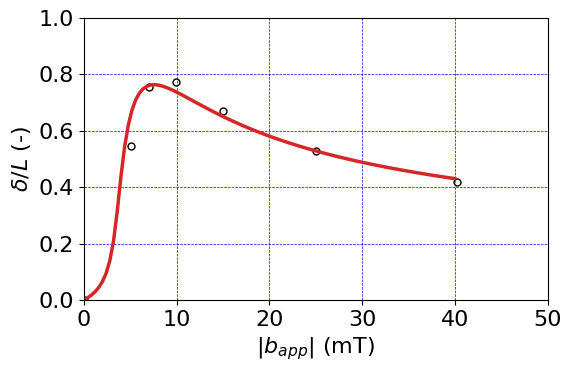

In [21]:
# Set up font size, initialize colors array
font = {'size'   : 16}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# only plot as far as time_out has time history for.
ind = np.argmax(timeHist0)

expData = np.genfromtxt('exp_data/Zhao_reversal_data.csv', delimiter=',')

plt.figure()
plt.scatter(expData[:,0] - expData[0,0], expData[:,1], s=25,
                     edgecolors=(0.0, 0.0, 0.0,1),
                     color=(1, 1, 1, 1),
                     label='Experiment', linewidth=1.0)
plt.plot(timeHist1[0:ind], timeHist2[0:ind]/scaleX, linewidth=2.5, c=colors[3] )
# plt.axvline(0, c='k', linewidth=1.)
# plt.axhline(0, c='k', linewidth=1.)
plt.axis('tight')
plt.xlabel(r"$|b_{app}|$ (mT)")
plt.ylabel(r"$\delta/L$ (-)")
plt.grid(linestyle="--", linewidth=0.5, color='b')
#plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.ylim(0, 1.0)
plt.xlim(0,50)

# save figure to file
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.tight_layout()
plt.savefig("results/Hardmagnetic_beam_reversal.png", dpi=600)